In [38]:
import numpy as np
import pandas as pd
import re

In [39]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer,WordNetLemmatizer

In [40]:
import datetime
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [41]:
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
pd.set_option('max_colwidth',400)

In [42]:
train_raw = pd.read_csv('./movie-review-sentiment-analysis-kernels-only/train.tsv', sep='\t')
test_raw = pd.read_csv('./movie-review-sentiment-analysis-kernels-only/test.tsv', sep='\t')

In [43]:
train_raw.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [44]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [45]:
train = train_raw
test = test_raw
train['text']=clean_review(train.Phrase.values)
test['text']=clean_review(test.Phrase.values)
y = train['Sentiment']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train.text.values,y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [47]:
vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1)
full_text = list(train['text'].values)
vectorizer.fit(full_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words=None, strip_accents='unicode', sublinear_tf=1,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

In [48]:
X_train_tfv =  vectorizer.transform(X_train)
X_test_tfv = vectorizer.transform(X_test)
test_tfv = vectorizer.transform(test['text'].values)

In [49]:
lr = LogisticRegression(C=1.0)
lr.fit(X_train_tfv, y_train)
predictions1 = lr.predict(X_test_tfv)
print("accuracy_score",accuracy_score(y_test, predictions1))

/home/hlz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hlz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy_score 0.6438549275919518


In [50]:
# Compute confusion matrix & plot
# Code adopted from Stackoverflow, credit to @Brad Solomon
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title+'.png')

Normalized confusion matrix
[[1.73e-01 4.81e-01 3.37e-01 9.90e-03 0.00e+00]
 [2.42e-02 3.69e-01 5.85e-01 2.13e-02 3.67e-04]
 [1.26e-03 4.59e-02 9.01e-01 5.09e-02 1.26e-03]
 [0.00e+00 1.43e-02 4.93e-01 4.64e-01 2.85e-02]
 [0.00e+00 6.51e-03 1.59e-01 5.91e-01 2.44e-01]]


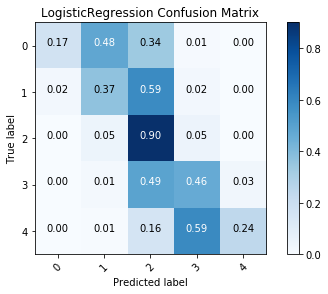

In [51]:
cm = confusion_matrix(y_test, predictions1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, normalize=True,classes=[0, 1,2,3,4],
                      title='LogisticRegression Confusion Matrix')

In [15]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10)

In [16]:
svc = LinearSVC()
svc.fit(X_train_tfv, y_train)
predictions2 = svc.predict(X_test_tfv)
print("accuracy_score",accuracy_score(y_test, predictions2))

pred2 = svc.predict(test_tfv)

# pred_res2 = pd.DataFrame()
# pred_res2['PhraseId'] = test['PhraseId']
# pred_res2['Sentiment'] = pd.DataFrame(pred2)

# pred_res2.to_csv('pred_res2.csv',index = False)

accuracy_score 0.6638472382417019


In [28]:
# Set the parameters by cross-validation
tuned_parameters = {'penalty': ['l1', 'l2'], 'tol': [1e-3, 1e-4, 1e-5],'C': [1, 10, 100]}

In [29]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LinearSVC(dual = False), tuned_parameters, cv=5, n_jobs = -1)
clf.fit(X_train_tfv, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'tol': [0.001, 0.0001, 1e-05], 'C': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
# Get the best params for SVC
clf.best_params_

{'C': 1, 'penalty': 'l1', 'tol': 0.0001}

In [52]:
svc_tuned = LinearSVC(C = 1, penalty = 'l1', tol= 0.0001, dual=False)
svc_tuned.fit(X_train_tfv, y_train)

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

Normalized confusion matrix
[[0.31 0.53 0.15 0.01 0.  ]
 [0.07 0.51 0.41 0.02 0.  ]
 [0.   0.08 0.84 0.08 0.  ]
 [0.   0.02 0.39 0.52 0.07]
 [0.   0.   0.07 0.57 0.36]]


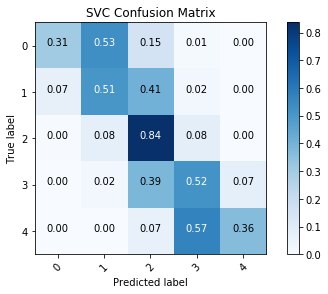

In [53]:
cm = confusion_matrix(y_test, svc_tuned.predict(X_test_tfv))
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, normalize=True,classes=[0,1,2,3,4],
                      title='SVC Confusion Matrix')

In [54]:
accuracy_score(y_test, svc_tuned.predict(X_test_tfv))

0.66000256311675